###	What are the key factors driving the probability of keeping a unit booked in the Austin area?  To answer this question, you can classify a unit as “booked” if the 90-day availability for the property is less than 40%.

##### Importing Libraries and Loading Data

In [257]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV




In [258]:
# load the cleaned data file into a pandas dataframe
df = pd.read_csv('airbnb_cleaned.csv')

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3973 entries, 0 to 3972
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   3973 non-null   int64  
 1   room_type                    3973 non-null   object 
 2   accommodates                 3973 non-null   int64  
 3   bathrooms                    3973 non-null   float64
 4   bedrooms                     3973 non-null   float64
 5   beds                         3973 non-null   float64
 6   bed_type                     3973 non-null   object 
 7   price                        3973 non-null   float64
 8   weekly_price                 3973 non-null   float64
 9   security_deposit             3973 non-null   float64
 10  cleaning_fee                 3973 non-null   float64
 11  guests_included              3973 non-null   int64  
 12  extra_people                 3973 non-null   float64
 13  minimum_nights    

#### Defining x and y

Next, we have to drop variables before creating the default decision tree. All the unnecessary columns were dropped in the cleaning process. Refer to the cleaning python file for the code used. Unnecessary columns included any text heavy features like summary, space, description, etc. In addition, categorical variables with more than 5 unique values were dropped, because that would likely work better with a multi-way split, and for the scope of this project, we decided to limit to binary splits for the decision tree.

In [260]:
# Create a new column 'booked_status' with 1 for booked and 0 for not booked
df['booked_status'] = df['availability_90'].apply(
    lambda x: 1 if x < 40 else 0
)

In [261]:
# change the booked status to category type
df['booked_status']= df['booked_status'].astype('category')

In [262]:
# define X
X = df.drop(columns = ['booked_status', 'availability_90'], axis=1)
X = X.drop(columns=['Unnamed: 0'])

# create dummies for 'room_type', 'bed_type', 'cancellation_policy'
X = pd.get_dummies(X, columns=['room_type', 'bed_type', 'cancellation_policy'], 
                                         drop_first=True)

# define y
y = df['booked_status']

In [263]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [264]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 2781 entries, 3655 to 3174
Series name: booked_status
Non-Null Count  Dtype   
--------------  -----   
2781 non-null   category
dtypes: category(1)
memory usage: 24.6 KB


In [265]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2781 entries, 3655 to 3174
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   accommodates                         2781 non-null   int64  
 1   bathrooms                            2781 non-null   float64
 2   bedrooms                             2781 non-null   float64
 3   beds                                 2781 non-null   float64
 4   price                                2781 non-null   float64
 5   weekly_price                         2781 non-null   float64
 6   security_deposit                     2781 non-null   float64
 7   cleaning_fee                         2781 non-null   float64
 8   guests_included                      2781 non-null   int64  
 9   extra_people                         2781 non-null   float64
 10  minimum_nights                       2781 non-null   int64  
 11  availability_30                 

#### Default Full Decision Tree

The following is a decision tree with the default parameters: max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001

In [266]:
# create an instance of a decision tree classifier using default values
dt_default = DecisionTreeClassifier(max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001)

# Train the model
dt_default.fit(X_train, y_train)

#text_rep = tree.export_text(dt_default)
#print(text_rep)

from sklearn.tree import export_text

# Assuming `dt_default` is your trained DecisionTreeClassifier and X_train is your training data
feature_names = X_train.columns  # Extract feature names from your training data
text_rep = export_text(dt_default, feature_names=list(feature_names))
print(text_rep)


|--- availability_60 <= 19.50
|   |--- availability_365 <= 314.50
|   |   |--- availability_60 <= 12.50
|   |   |   |--- class: 1
|   |   |--- availability_60 >  12.50
|   |   |   |--- availability_365 <= 297.50
|   |   |   |   |--- class: 1
|   |   |   |--- availability_365 >  297.50
|   |   |   |   |--- class: 0
|   |--- availability_365 >  314.50
|   |   |--- class: 0
|--- availability_60 >  19.50
|   |--- availability_60 <= 30.50
|   |   |--- availability_365 <= 309.50
|   |   |   |--- number_of_reviews <= 4.50
|   |   |   |   |--- availability_365 <= 216.50
|   |   |   |   |   |--- cancellation_policy_moderate <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- cancellation_policy_moderate >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- availability_365 >  216.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- number_of_reviews >  4.50
|   |   |   |   |--- number_of_reviews <= 33.50
|   |   |   |   |   |--- availability_365 <= 148.50
|   | 

Making prediction 

In [267]:
# make predictions on the training and test data
y_pred_train = dt_default.predict(X_train)
y_pred_test = dt_default.predict(X_test)

y_prob_train = dt_default.predict_proba(X_train)
y_prob_test = dt_default.predict_proba(X_test)

Model accuracy

In [268]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.9741
Precision: 0.9499
Recall.  : 0.9550

 -- test set -- 
Accuracy : 0.9614
Precision: 0.9185
Recall.  : 0.9361


Here, the decision tree is being overfitted, because there is a huge gap between the test and train data values. This suggests that we need to investigate methods of pruning/tuning the decision tree. An imbalanced split between booked and not booked mkight cause bias in the data. Or we can adjust the the decision tree parameters to produce the tuned tree. 

#### Editing Repeated Features on the Decision Tree - Default Decision Tree 2

When we observed the default decision tree, we noticed that most of the splits occured on the basis of the availability_30, availability_60, and availability_365 features. Since booked_status is drawn from availability_90, we have reason to believe that there is high multicolinearity between these features. And, from a business perspective, availability indicates interest in the unit over different spans of time. Though this might be important, we are removing all these columns from the following decision tree to ensure low multicolinearity, and offer other explanantions for booked_status.

In [269]:
# redefine x
X = X.drop(columns=['availability_30', 'availability_60', 'availability_365'])

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [270]:
# create an instance of a decision tree classifier using default values
dt_default2 = DecisionTreeClassifier(max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001)

# Train the model
dt_default2.fit(X_train, y_train)

from sklearn.tree import export_text

# Assuming `dt_default` is your trained DecisionTreeClassifier and X_train is your training data
feature_names = X_train.columns  # Extract feature names from your training data
text_rep = export_text(dt_default2, feature_names=list(feature_names))
print(text_rep)


|--- number_of_reviews <= 15.50
|   |--- room_type_Private room <= 0.50
|   |   |--- cleaning_fee <= 67.00
|   |   |   |--- minimum_nights <= 2.50
|   |   |   |   |--- extra_people <= 24.50
|   |   |   |   |   |--- security_deposit <= 449.50
|   |   |   |   |   |   |--- review_scores_accuracy <= 9.50
|   |   |   |   |   |   |   |--- review_scores_rating <= 93.50
|   |   |   |   |   |   |   |   |--- review_scores_communication <= 9.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- review_scores_communication >  9.50
|   |   |   |   |   |   |   |   |   |--- number_of_reviews <= 4.50
|   |   |   |   |   |   |   |   |   |   |--- number_of_reviews <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- number_of_reviews >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- number_of_reviews >  4.50
|   |   |   |   |   |   |   |   |   |   |--- cl

In [271]:
# make predictions on the training and test data
y_pred_train = dt_default2.predict(X_train)
y_pred_test = dt_default2.predict(X_test)

y_prob_train = dt_default2.predict_proba(X_train)
y_prob_test = dt_default2.predict_proba(X_test)

In [272]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.7598
Precision: 0.7351
Recall.  : 0.1801

 -- test set -- 
Accuracy : 0.7391
Precision: 0.5139
Recall.  : 0.1182


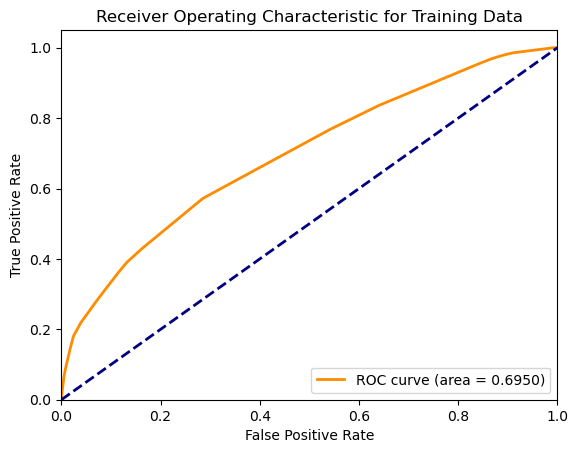

In [273]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

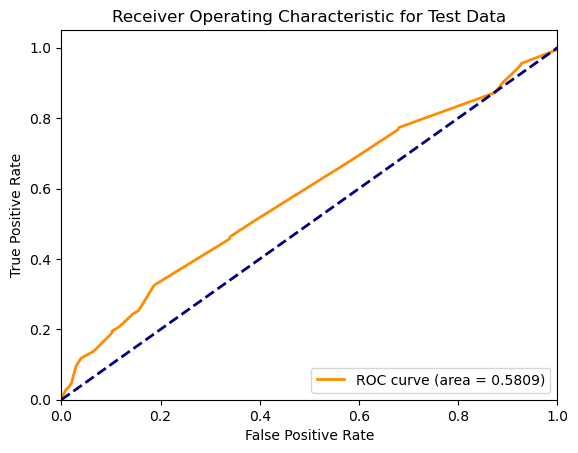

In [274]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

Accuracy values for this model are good, precision and recall values show overfitting. Recall is especially low.

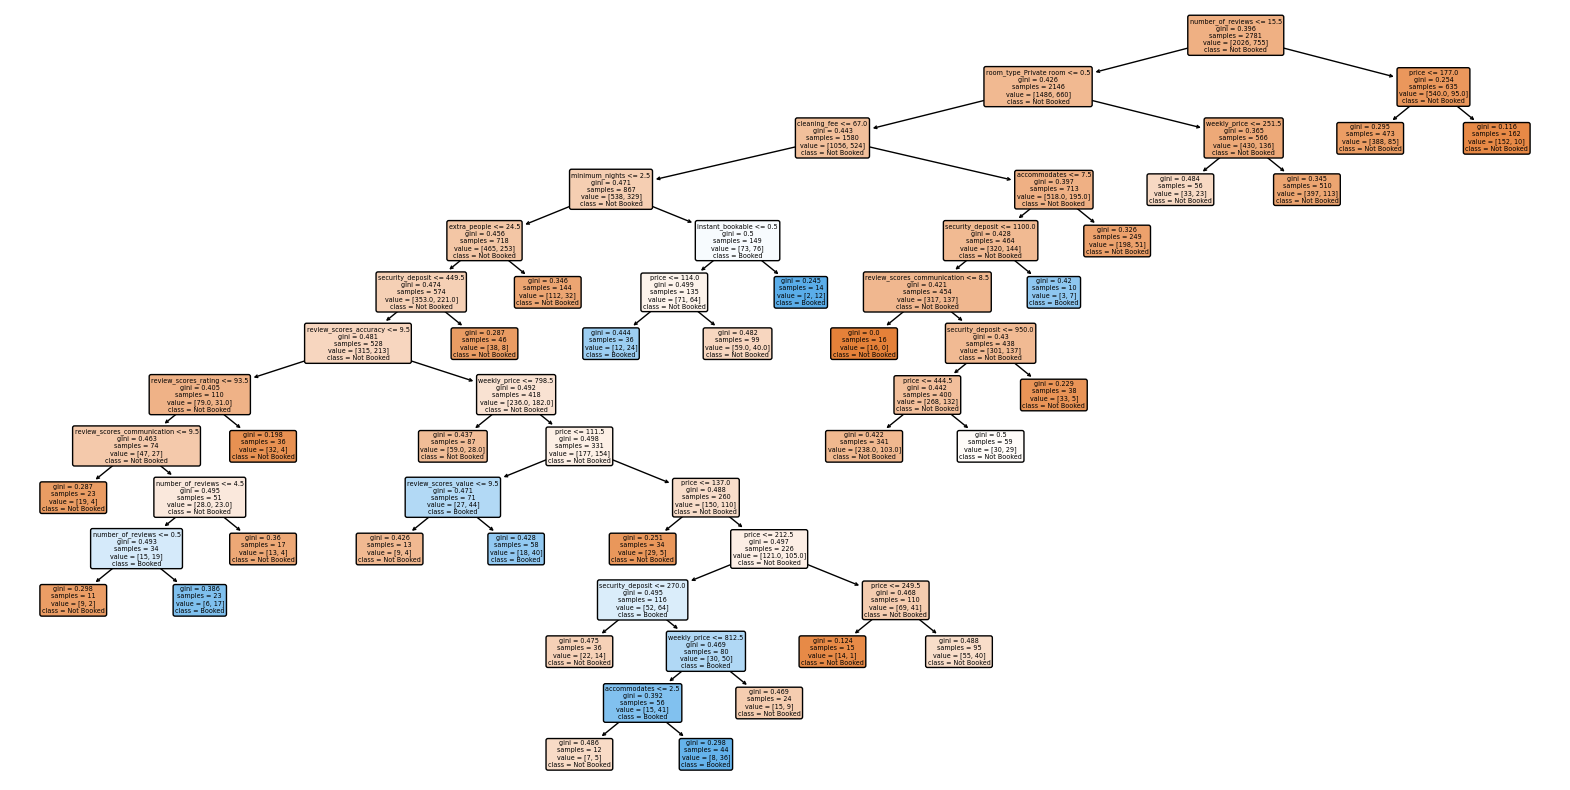

In [275]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Create a plot of the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(
    dt_default2, 
    feature_names=X_train.columns.tolist(), 
    class_names=["Not Booked", "Booked"], 
    filled=True, 
    rounded=True
)

# Save the plot to a PDF
plt.savefig("tree.pdf", format="pdf")

# Optionally, display the plot
plt.show()

Max depth is too high here, so in the tuned models, we will change that.

#### Checking for Imbalance

When we checked for imbalance. The data showed a heavy skew towards 0 (not booked). So we attempted to fix it by balancing class weights.

In [276]:
# checking for imbalance in the count for each
print(y_train.value_counts())

booked_status
0    2026
1     755
Name: count, dtype: int64


In [277]:
from sklearn.metrics import classification_report

#fixing imbalance for better Decision Tree
dt_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth = 25, min_samples_leaf=10, ccp_alpha = 0.001)
dt_balanced.fit(X_train, y_train)

# make predictions on the training and test data
y_pred_train = dt_balanced.predict(X_train)
y_pred_test = dt_balanced.predict(X_test)

y_prob_train = dt_balanced.predict_proba(X_train)
y_prob_test = dt_balanced.predict_proba(X_test)

# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.6962
Precision: 0.4648
Recall.  : 0.7868

 -- test set -- 
Accuracy : 0.5713
Precision: 0.3275
Recall.  : 0.6006


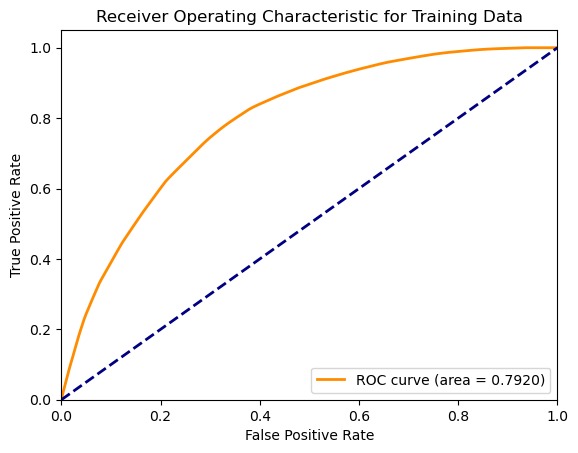

In [278]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

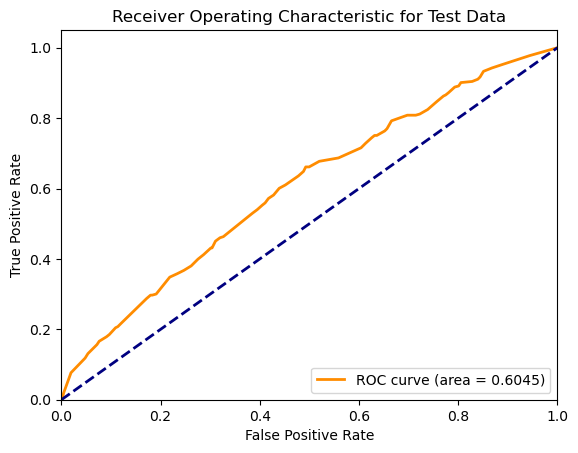

In [279]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

So we tried to balance the class weight and keep all the parameters to see how that would change the model accuracy. The difference in test and train accuracy, presicion and recall values shows that there is high overfitting compared to Default Decision Tree 2. At this point, balancing the class weights is not helping the overfitting even though the recall improved. To try another approach, we will find the best combination of parameters for the tuned decision tree.

#### Tuned Decision Tree Parameter Check

In [280]:
dt_tune = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 10, 20, 50, 100],
    'ccp_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(dt_tune, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0.01, 'max_depth': None, 'min_samples_leaf': 1}
DecisionTreeClassifier(ccp_alpha=0.01)


Max_depth = none and min_leaf = 1 here, which does not make sense, so we worked through trial and error. Not all the tuned models we tried are shown below, but we experimented with max_depth values 4, 5, 6, 7, 10, 15, and 20. 

#### Tuned Decision Tree Max-depth = 4 (CHOSEN DECISION TREE)

In [281]:
dt_tuned = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=4,
    min_samples_leaf=10, 
    ccp_alpha=0.001,
    random_state=42 
)
dt_tuned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=4,
                       min_samples_leaf=10, random_state=42)

In [282]:
# make predictions on the training and test data
y_pred_train = dt_tuned.predict(X_train)
y_pred_test = dt_tuned.predict(X_test)

y_prob_train = dt_tuned.predict_proba(X_train)
y_prob_test = dt_tuned.predict_proba(X_test)

In [283]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.5602
Precision: 0.3488
Recall.  : 0.7152

 -- test set -- 
Accuracy : 0.5344
Precision: 0.3199
Recall.  : 0.6869


Overfitting is the lowest in this model, because the train and test values are closer. Additionally, recall is notably higher, which is what we are interested in from a business perspective since it is important for Airbnb to know CORRECTLY whether a unit will be booked.

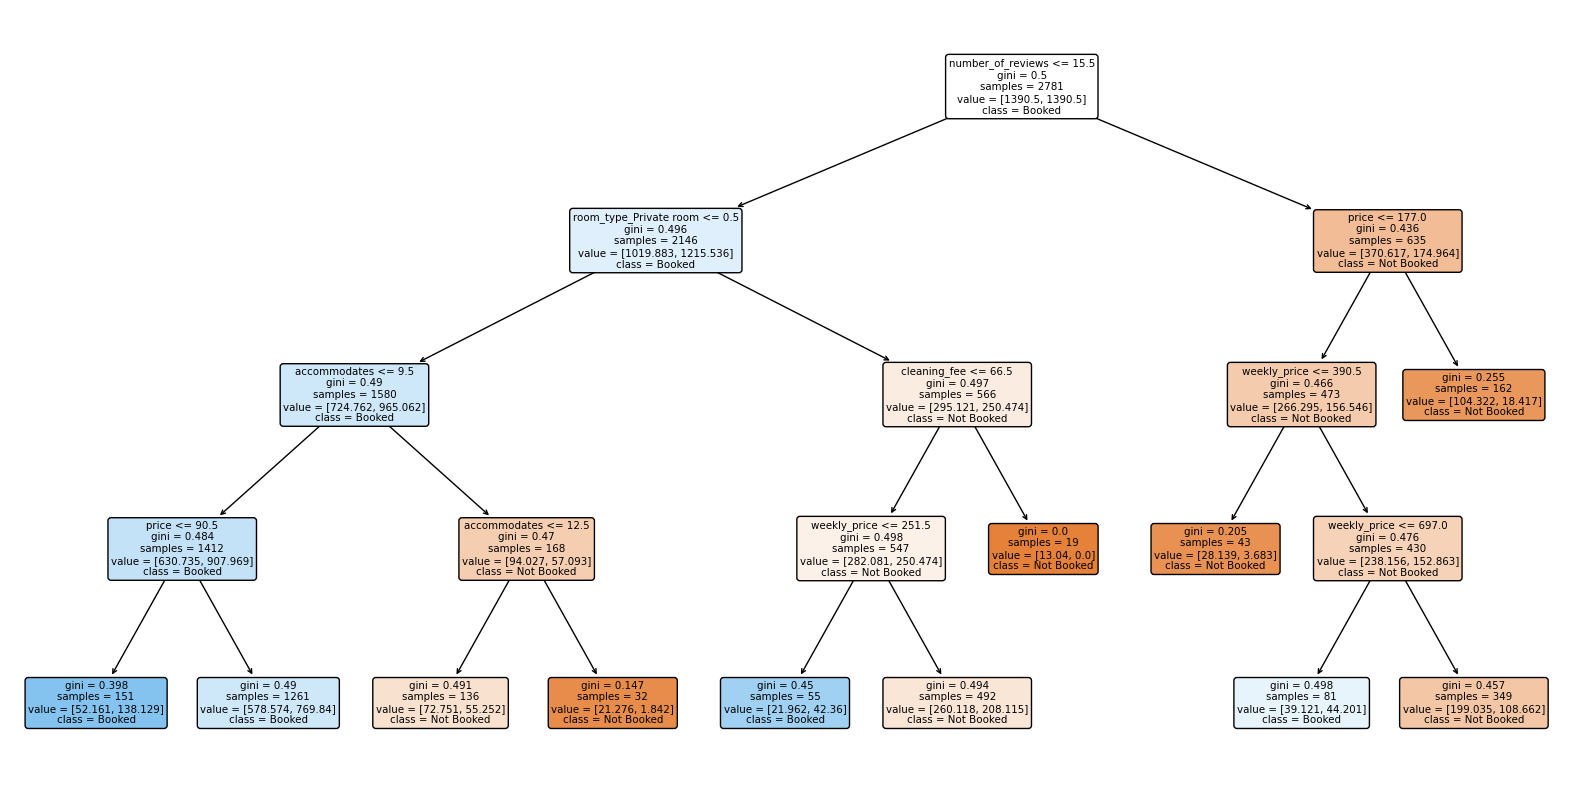

In [284]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Create a plot of the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(
    dt_tuned, 
    feature_names=X_train.columns.tolist(), 
    class_names=["Not Booked", "Booked"], 
    filled=True, 
    rounded=True
)

# Save the plot to a PDF
plt.savefig("tree.pdf", format="pdf")

# Optionally, display the plot
plt.show()

#### Tuned Decision Tree Mxx-depth = 6

In [285]:
dt_tuned2 = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=6, 
    min_samples_leaf=10, 
    ccp_alpha=0.001,
    random_state=42 
)
dt_tuned2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=6,
                       min_samples_leaf=10, random_state=42)

In [286]:
# make predictions on the training and test data
y_pred_train = dt_tuned2.predict(X_train)
y_pred_test = dt_tuned2.predict(X_test)

y_prob_train = dt_tuned2.predict_proba(X_train)
y_prob_test = dt_tuned2.predict_proba(X_test)

In [287]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.6023
Precision: 0.3790
Recall.  : 0.7285

 -- test set -- 
Accuracy : 0.5604
Precision: 0.3256
Recall.  : 0.6294


Overfitting present, difference is about 8-10% between train and test data.

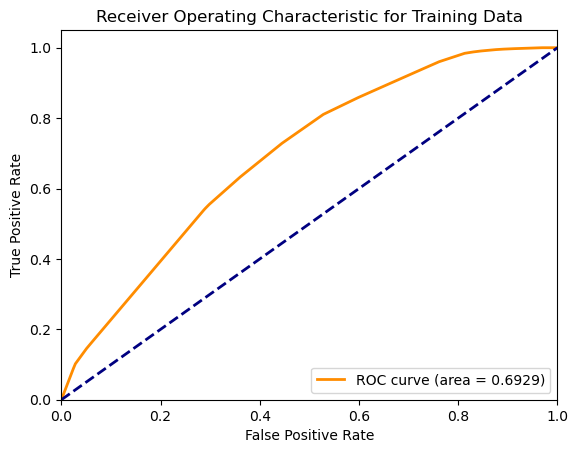

In [288]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

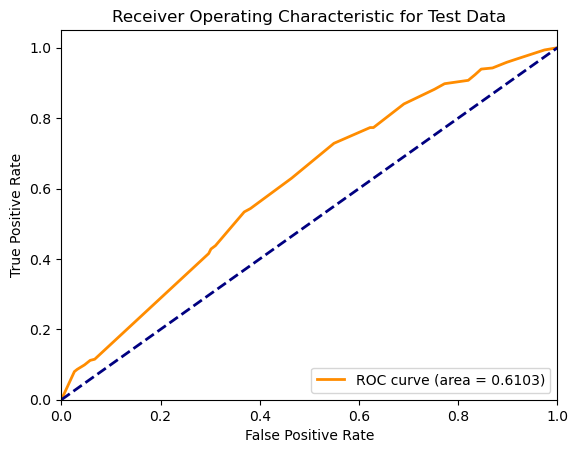

In [289]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

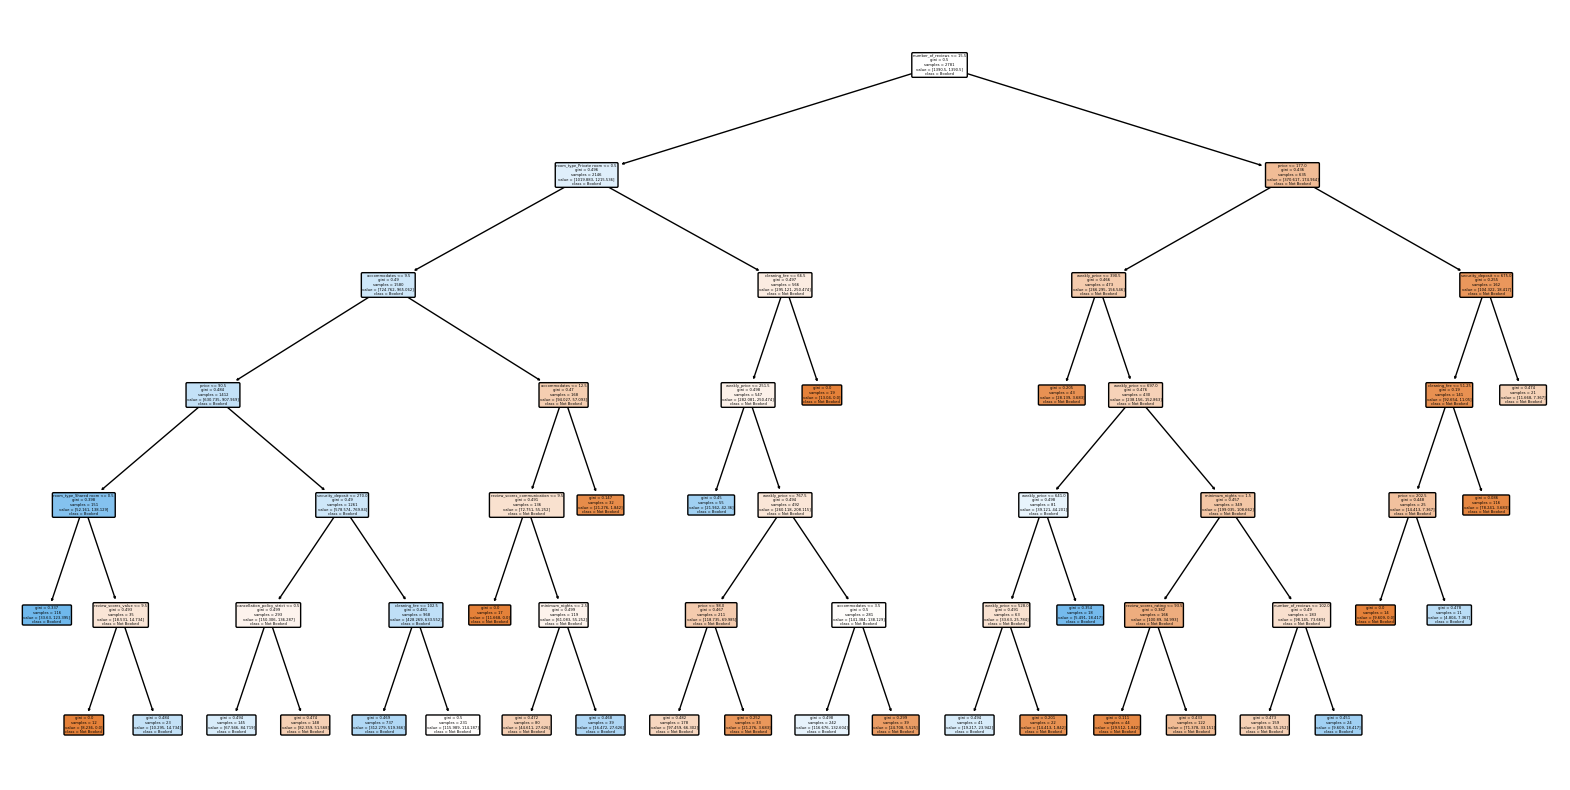

In [290]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Create a plot of the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(
    dt_tuned2, 
    feature_names=X_train.columns.tolist(), 
    class_names=["Not Booked", "Booked"], 
    filled=True, 
    rounded=True
)

# Save the plot to a PDF
plt.savefig("tree.pdf", format="pdf")

# Optionally, display the plot
plt.show()
